## Week 14 : Generative Adversarial Networks
```
- Machine Learning, Innopolis University
- Professor: Adil Khan
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
Lab Plan
    1. Vanila GAN achitecture
    2. GAN training procedure
```

<hr>

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. Vannila Generative adversarial network (GAN)

![caption](https://www.researchgate.net/profile/Zhaoqing-Pan/publication/331756737/figure/fig1/AS:736526694621184@1552613056409/The-architecture-of-generative-adversarial-networks.png)

### 1.1 Dataset

For this lesson we will use SVHN dataset which readily available in `torchvision` and we will do minimal transformation operations

Install `torchvision` : `pip install torchvision`

### Task : Normalize the data

In [4]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms


def normalize(data_tensor):
    '''re-scale image values to [-1, 1]'''
    return (data_tensor / 255.) * 2. - 1.

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: normalize(x))])

# SVHN training datasets
svhn_train = datasets.SVHN(root='data/', split='train', download=True, transform=transform)

batch_size = 128
num_workers = 0

# build DataLoaders for SVHN dataset
train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

100%|██████████| 182040794/182040794 [00:28<00:00, 6299468.86it/s]


In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## 1.2 Generator & Discriminator Definition

![](https://www.researchgate.net/publication/336144594/figure/fig2/AS:808881324322820@1569863744938/An-example-of-the-deconvolution-process-using-transpose-convolution-In-the-figure.png)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
#ngf : Number of generator filters
#ndf : Number of discriminator filters
nz = 32
class Discriminator(nn.Module):

    def __init__(self, ndf=3, conv_dim=32):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, 1, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1),
            nn.Flatten(),
            nn.Linear(5*5,1),
            nn.Sigmoid()
          )


    def forward(self, x):
        # Step 1: pass the input (real or fake samples) through all hidden layers
        return self.model(x)

class Generator(nn.Module):

    def __init__(self, z_size, ngf, conv_dim=32):
        super(Generator, self).__init__()
        # Step 1: Define the generator network architecture
        # NOTE: the input is the random noise size and output is conv_dim i.e (3,32,32)
        self.conv_dim = conv_dim
        self.input_layer = nn.Linear(in_features=z_size, out_features=2048, bias=True)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 128, out_channels=ngf * 2, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features= ngf * 2),
            nn.Tanh(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features=ngf),
            nn.Tanh(),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, x):
      # Step 1: pass the input which is random noise to generate the face samples
      x = self.input_layer(x)
      x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
      return self.model(x)

## 1.3 Set hyperparams and training parameters

In [7]:
# define hyperparams
conv_dim = 32
z_size = 100
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define discriminator and generator
D = Discriminator(conv_dim).to(device)
G = Generator(z_size=z_size, ngf=3,conv_dim=conv_dim).to(device)

#print the models summary
print(D)
print()
print(G)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=25, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

Generator(
  (input_layer): Linear(in_features=100, out_features=2048, bias=True)
  (model): Sequential(
    (0): ConvTranspose2d(128, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): ConvTranspose2d(6, 3

## 1.4 Define the loss function for D(x) and G(x)

In [8]:
import torch.optim as optim

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels
        labels = torch.FloatTensor(batch_size).uniform_(0.9, 1).to(device)
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available

    labels = labels.to(device)
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.FloatTensor(batch_size).uniform_(0, 0.1).to(device) # fake labels = 0
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

# params
learning_rate = 0.0003
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), learning_rate)
g_optimizer = optim.SGD(G.parameters(), learning_rate)

## 1.5 GAN training Loop

Epoch [0/10], Discriminator Loss: 1.0668, Generator Loss: 0.6877
Epoch [1/10], Discriminator Loss: 1.0593, Generator Loss: 0.6917
Epoch [2/10], Discriminator Loss: 1.0572, Generator Loss: 0.6925
Epoch [3/10], Discriminator Loss: 1.0566, Generator Loss: 0.6928
Epoch [4/10], Discriminator Loss: 1.0595, Generator Loss: 0.6930
Epoch [5/10], Discriminator Loss: 1.0569, Generator Loss: 0.6930
Epoch [6/10], Discriminator Loss: 1.0627, Generator Loss: 0.6931
Epoch [7/10], Discriminator Loss: 1.0575, Generator Loss: 0.6931
Epoch [8/10], Discriminator Loss: 1.0594, Generator Loss: 0.6931
Epoch [9/10], Discriminator Loss: 1.0521, Generator Loss: 0.6931


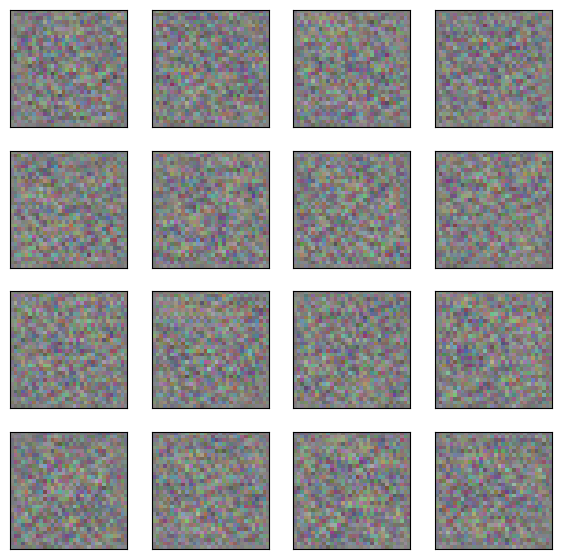

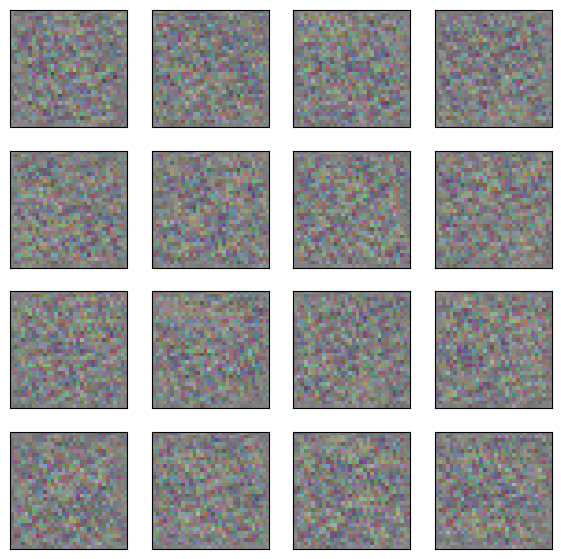

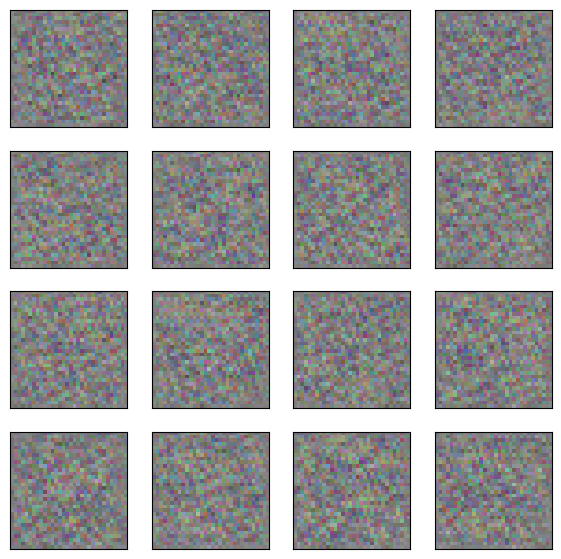

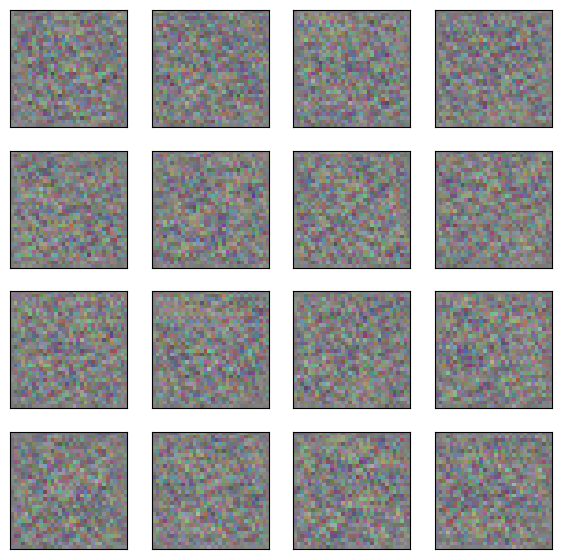

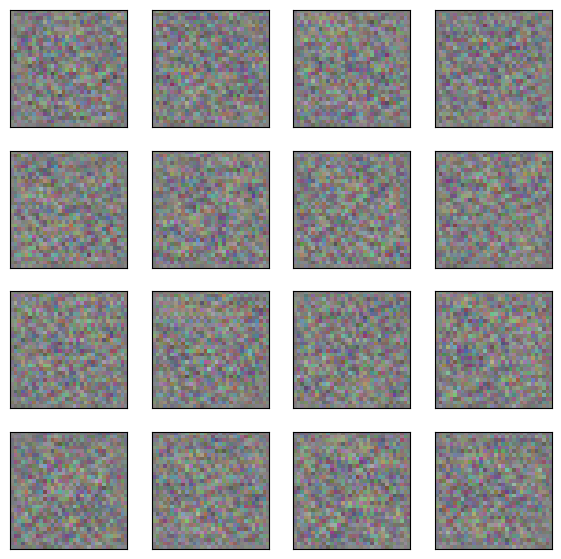

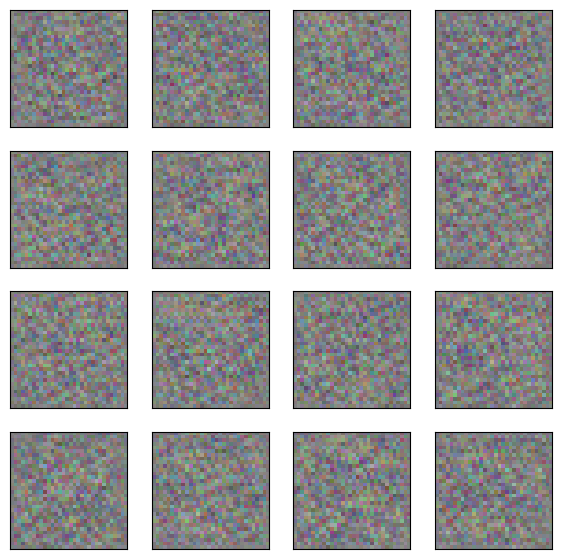

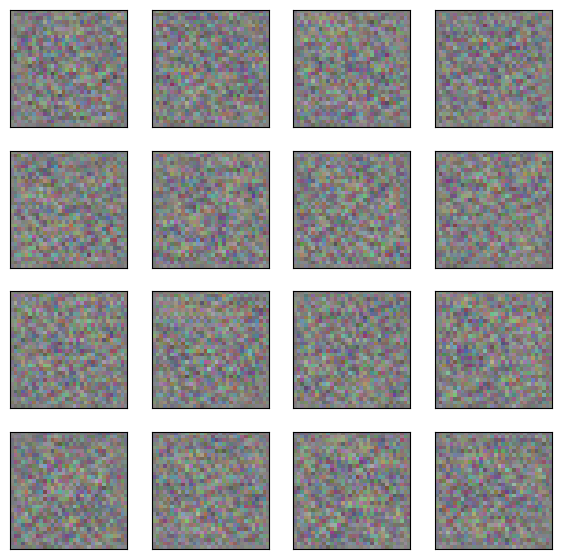

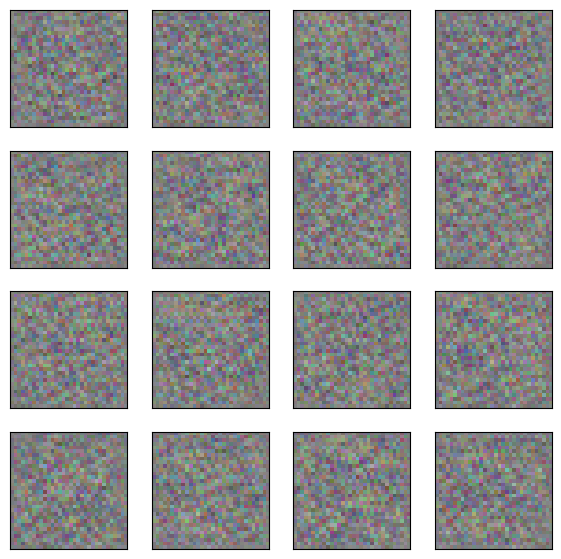

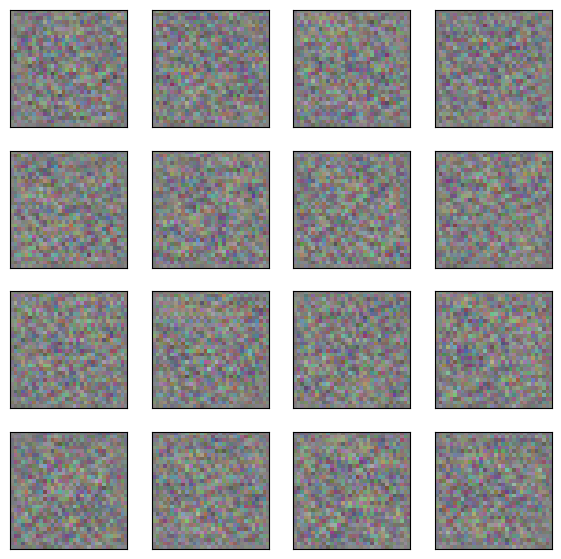

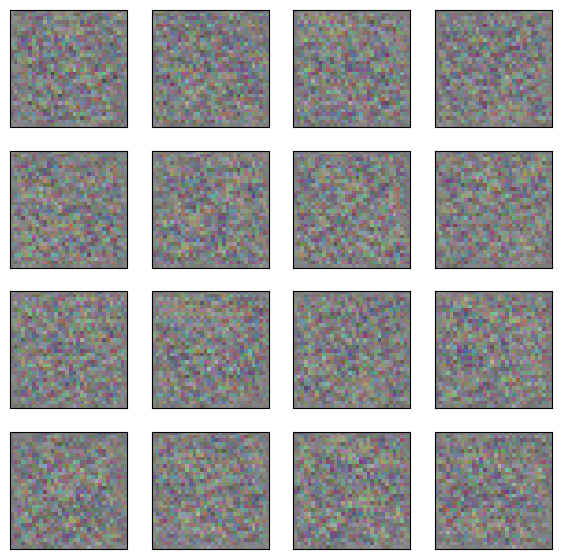

In [9]:
# keep track of loss and generated, "fake" samples
losses = []

print_every = 1

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):

    for batch_i, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)

        # TRAIN THE DISCRIMINATOR
        d_optimizer.zero_grad()

        # Train with real images
        real_images = real_images.to(device)
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        # Train with fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        # Total discriminator loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # TRAIN THE GENERATOR
        g_optimizer.zero_grad()

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)

        # Compute the discriminator losses on fake images using flipped labels
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)  # Use real_loss for generator

        # Perform backprop and take optimizer step
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # Append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))

    # Print some loss stats
    if epoch % print_every == 0:
        print(f"Epoch [{epoch}/{num_epochs}], "
              f"Discriminator Loss: {d_loss.item():.4f}, "
              f"Generator Loss: {g_loss.item():.4f}")

    # Save generated samples
    G.eval()  # Set generator to evaluation mode
    samples_z = G(fixed_z.to(device))
    G.train()  # Set generator back to training mode

    # Output generated samples
    if epoch % print_every == 0:
        fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
        for ax, img in zip(axes.flatten(), samples_z):
            img = img.detach().cpu().numpy()
            img = np.transpose(img, (1, 2, 0))
            img = ((img + 1) * 0.5 * 255).astype(np.uint8)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((32, 32, 3)))



## NOTE
Keep in mind:

1. Always use a learning rate for discriminator higher than the generator.
2. Keep training even if you see that the losses are going up.
3. There are many variations with different loss functions which are worth exploring.
4. If you get mode collapse, lower the learning rates.
5. Adding noise to the training data helps make the model more stable.
6. Label Smoothing: instead of making the labels as 1 make it 0.9


## Resources

* [Deconvolutional Networks](https://www.matthewzeiler.com/mattzeiler/deconvolutionalnetworks.pdf)
* [PyTorch `ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)
* [Computational Imaging and Display](https://stanford.edu/class/ee367/reading/lecture6_notes.pdf)